<a id='top'></a><a name='top'></a>
# Chapter 2: Build your vocabulary (word tokenization)

* [Introduction](#introduction)
* [2.0 Imports and Setup](#2.0)
* [2.1 Challenges (a preview of learning)](#2.1)
* [2.2 Building your vocabulary with a tokenizer](#2.2)
     - [2.2.1 Dot product](#2.2.1)
     - [2.2.2 Measuring bag-of-words overlap](#2.2.2)
     - [2.2.3 A token improvement](#2.2.3) 
     - [2.2.4 Extending your vocabulary with n-grams](#2.2.4)
     - [2.2.5 Normalizing your vocabulary](#2.2.5)
* [2.3 Sentiment](#2.3)
    - [2.3.1 VADER - A rule-based sentiment analyzer](#2.3.1)
    - [2.3.2 Naive Bayes](#2.3.2)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset

* movieReviewSnippets_GroundTruth.csv.gz: [script](#movieReviewSnippets_GroundTruth.csv.gz), [source](https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/hutto_ICWSM_2014/movieReviewSnippets_GroundTruth.csv.gz)
* amazonReviewSnippets_GroundTruth.csv.gz: [script](#amazonReviewSnippets_GroundTruth.csv.gz), [source](https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/hutto_ICWSM_2014/amazonReviewSnippets_GroundTruth.csv.gz)

### Explore

* Tokenizing text into words and n-grams (tokens)
* Dealing with nonstandard punctuation and emoticons, like social media posts
* Compressing token vocabulary  with stemming and lemmatization
* Building a vector representation of a statement
* Building a sentiment analyzer from handcrafted token scores


### Key points

* Implement tokenization and configure a tokenizer for an application.
* n-gram tokenization helps retain some of the word order information in a document.
* Normalization and stemming consolidate words into groups that improve the "recall" for search engines but reduce precision.
* Lemmatization and customized tokenizers like `casual_tokenize()` can improve precision and reduce information loss.
* Stop words can contain useful information and discarding them is not always helpful.
* In natural language processing, composing a numerical vector from text is a particularly "lossy" feature extraction process.


---
<a name='2.0'></a><a id='2.0'></a>
# 2.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
import os
if not os.path.exists('setup'):
    os.mkdir('setup')

In [2]:
req_file = "setup/requirements_02.txt"

In [3]:
%%writefile {req_file}
isort
scikit-learn-intelex
vaderSentiment
watermark

Overwriting setup/requirements_02.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
#if IS_COLAB:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [121]:
%%writefile setup/chp02_imports.py
import locale
import pprint
import random
import re
import warnings
from collections import Counter

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import casual_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import \
    ENGLISH_STOP_WORDS as sklearn_stop_words
from sklearn.naive_bayes import MultinomialNB
from tqdm.auto import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from watermark import watermark

Overwriting setup/chp02_imports.py


In [122]:
!isort setup/chp02_imports.py --sl
!cat setup/chp02_imports.py

import locale
import pprint
import random
import re
import warnings
from collections import Counter

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import casual_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import \
    ENGLISH_STOP_WORDS as sklearn_stop_words
from sklearn.naive_bayes import MultinomialNB
from tqdm.auto import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from watermark import watermark


In [123]:
import locale
import pprint
import random
import re
import warnings
from collections import Counter

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import casual_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import \
    ENGLISH_STOP_WORDS as sklearn_stop_words
from sklearn.naive_bayes import MultinomialNB
from tqdm.auto import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from watermark import watermark

In [124]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)
random.seed(23)

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

pandas : 1.5.3
re     : 2.2.1
numpy  : 1.23.5
seaborn: 0.12.1
nltk   : 3.8
sys    : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]



In [125]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/gb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<a name='2.1'></a><a id='2.1'></a>
# 2.1 Challenges

## A preview of stemming
<a href="#top">[back to top]</a>

Problem: How can we create representations of the same cluster of words?

Idea: Stemming is a basic strategy to group various inflections of a word into the same "bucket" or cluster.

<a name='2.2'></a><a id='2.2'></a>
## 2.2 Building your vocabulary with a tokenizer
<a href="#top">[back to top]</a>

Problem: How to transform unstructured data, natural language text, into units of information that are countable discrete elements?

Idea: Use a tokenizer to segment text into tokens. The simplest method to tokenize a sentence is to split on whitespace as the "delimeter" of words. After this is done, we can create vector representations for each word, which are called *one-hot* vectors. This solves the first problem of NLP, which is to transform words into numbers. 

Tokenization is the first step in an NLP pipeline, so it can have a big impact on the rest of your pipeline. A tokenizer breaks unstructured data, natural language text, into chunks of information that can be counted as discrete elements. These counts of token occurrences in a document can be used directly as a vector representing that document. This immediately turns an unstructured string (text document) into a numerical data structure suitable for machine learning. The most common use for bag-of-words vectors created this way is for document retrieval, or search.

In [126]:
sentence = """Thomas Jefferson began building Monticello at the age of 26."""
sentence.split()

['Thomas',
 'Jefferson',
 'began',
 'building',
 'Monticello',
 'at',
 'the',
 'age',
 'of',
 '26.']

In [127]:
token_sequence = str.split(sentence)
vocab = sorted(set(token_sequence))

In [128]:
', '.join(vocab)

'26., Jefferson, Monticello, Thomas, age, at, began, building, of, the'

In [129]:
num_tokens = len(token_sequence)
num_tokens

10

In [130]:
vocab_size = len(vocab)
vocab_size

10

In [131]:
onehot_vectors = np.zeros((num_tokens, vocab_size), int)
onehot_vectors

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In programming terms, a one-hot vector is akin to a Python `list`.

In [132]:
# Create simple one-hot vector
# For each word in the sentence, mark the column 
# for that word in your vocabulary with a 1.
for i, word in enumerate(token_sequence):
    onehot_vectors[i, vocab.index(word)] = 1

In [133]:
# Representation of this one-sentence document.
onehot_vectors

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [134]:
# Check
' '.join(vocab)

'26. Jefferson Monticello Thomas age at began building of the'

In [135]:
Counter("Guten Morgen Rosa".split())

Counter({'Guten': 1, 'Morgen': 1, 'Rosa': 1})

We can use Pandas for a more legible dataset, since we can label each column with the token it represents. 

In [136]:
# Listing 2.2 One-hot vector sequence for the Monticello sentence
pd.DataFrame(onehot_vectors, columns=vocab)

,26.,Jefferson,Monticello,Thomas,age,at,began,building,of,the
0,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0
9,1,0,0,0,0,0,0,0,0,0


In [137]:
# Listing 2.3 Prettier one-hot vectors
df = pd.DataFrame(onehot_vectors, columns=vocab)
df[df == 0] = ''
df

,26.,Jefferson,Monticello,Thomas,age,at,began,building,of,the
0,,,,1,,,,,,
1,,1,,,,,,,,
2,,,,,,,1,,,
3,,,,,,,,1,,
4,,,1,,,,,,,
5,,,,,,1,,,,
6,,,,,,,,,,1
7,,,,,1,,,,,
8,,,,,,,,,1,
9,1,,,,,,,,,


The main disadvantage of one-hot encoding is that a long document can result in a huge vector size needed for a one-hot vector representation. This can result in a very sparse, inefficient data structure. 

In [138]:
# Assume 3000 books with 3500 sentences each, 
# and 15 rods per sentence.
num_rows = 3000 * 3500 * 15
f"{num_rows:,}"

'157,500,000'

In [139]:
# Assume a million tokens in the NLP pipeline vocabulary.
# If we assume a single bit for matrix cell, calculate necessary memory.
num_bytes = num_rows * 1_000_000
f"{num_bytes:,}"

'157,500,000,000,000'

In [140]:
gb = num_bytes / 1e9 # gigabytes
gb

157500.0

In [141]:
gb / 1000 # terabytes

157.5

As an alternative, we want to compress the meaning of a document down to a single vector, rather than a big table. 

One alternative is to organize tokens into a bag-of-words vector. This is a word frequency vector, since it only counts the frequence of words, not their order. We can use this single vector to represent a whole document in a single, reasonable-length vector. It would only be as long as the number of unique tokens we want to keep track of.

In programming terms, this is akin to a Python `dict`.

In [142]:
# Put tokens into a binary vector indicating the presence or absence of 
# a particular word in a particular sentence, similar to a book index.
# How a single text document looks like as a binary bag-of-words vector
sentence_bow = {}
for token in sentence.split():
    sentence_bow[token] = 1

sentence_bow

{'Thomas': 1,
 'Jefferson': 1,
 'began': 1,
 'building': 1,
 'Monticello': 1,
 'at': 1,
 'the': 1,
 'age': 1,
 'of': 1,
 '26.': 1}

In [143]:
sorted(sentence_bow.items())

[('26.', 1),
 ('Jefferson', 1),
 ('Monticello', 1),
 ('Thomas', 1),
 ('age', 1),
 ('at', 1),
 ('began', 1),
 ('building', 1),
 ('of', 1),
 ('the', 1)]

In [144]:
sentence_bow_sorted = dict([(token, 1) for token in sentence.split()])
sentence_bow_sorted

{'Thomas': 1,
 'Jefferson': 1,
 'began': 1,
 'building': 1,
 'Monticello': 1,
 'at': 1,
 'the': 1,
 'age': 1,
 'of': 1,
 '26.': 1}

In [145]:
df = pd.DataFrame(pd.Series(sentence_bow_sorted), columns=['sent']).T
df

,Thomas,Jefferson,began,building,Monticello,at,the,age,of,26.
sent,1,1,1,1,1,1,1,1,1,1


In [146]:
# Listing 2.4 Construct a DataFrame of bag-of-words vectors
sentences = """Thomas Jefferson began building Monticello at the age of 26.\n"""
sentences += """Construction was done mostly by local masons and carpenters.\n"""
sentences += """He moved into the South Pavilion in 1770.\n"""
sentences += """Turning Monticello into a neoclassical masterpiece was Jefferson's obsession."""
corpus = {}

# sentences = """Thomas Jefferson began building Monticello at the age of 26.
# Construction was done mostly by local masons and carpenters.
# He moved into the South Pavilion in 1770.
# Turning Monticello into a neoclassical masterpiece was Jefferson's obsession."""

corpus = {}

for i, sent in enumerate(sentences.split('\n')):
    corpus['sent{}'.format(i)] = dict((tok, 1) for tok in sent.split())

df = pd.DataFrame.from_records(corpus).fillna(0).astype(int).T
df[df.columns[:10]]

,Thomas,Jefferson,began,building,Monticello,at,the,age,of,26.
sent0,1,1,1,1,1,1,1,1,1,1
sent1,0,0,0,0,0,0,0,0,0,0
sent2,0,0,0,0,0,0,1,0,0,0
sent3,0,0,0,0,1,0,0,0,0,0


<a name='2.2.1'></a><a id='2.2.1'></a>
### 2.2.1 Dot product
<a href="#top">[back to top]</a>

Problem: Need a way to check for similarities between sentences.

Idea: Count the number of overlapping tokens using a *dot product*. This produces a single scalar value.

In [147]:
# Listing 2.5 Example dot product calculation
v1 = np.array([1,2,3])
v2 = np.array([2,3,4])
v1.dot(v2)

20

In [148]:
(v1 * v2)

array([ 2,  6, 12])

In [149]:
(v1 * v2).sum()

20

In [150]:
sum([x1 * x2 for x1, x2 in zip(v1, v2)])

20

<a name='2.2.2'></a><a id='2.2.2'></a>
### 2.2.2 Measuring bag-of-words overlap
<a href="#top">[back to top]</a>

Problem: Need an estimate of how similar two vectors are in the words they use (assuming we can measure the bag of words overlap).

Idea: Estimate bag-of-words vector overlap between new sentences and original sentences. This is our first vector space model (VSM) of natural language documents.

In [151]:
# Listing 2.6 Overlap of word counts for two bag-of-words vectors
df2 = df.T

In [152]:
Counter("Good morning, Rosa!".split())

Counter({'Good': 1, 'morning,': 1, 'Rosa!': 1})

In [153]:
# Sentence 0
' '.join(corpus['sent0'])

'Thomas Jefferson began building Monticello at the age of 26.'

In [154]:
# Sentence 1
' '.join(corpus['sent1'])

'Construction was done mostly by local masons and carpenters.'

In [155]:
# Sentence 2
' '.join(corpus['sent2'])

'He moved into the South Pavilion in 1770.'

In [156]:
# Sentence 3
' '.join(corpus['sent3'])

"Turning Monticello into a neoclassical masterpiece was Jefferson's obsession."

In [157]:
# The maximum, overlap of word counts for two identical sentences.
print(df2.sent0.dot(df2.sent0))

10


In [158]:
# No words were used in both sent0 and sent1
df2.sent0.dot(df2.sent1)

0

In [159]:
# One word was used in both sent0 and sent2
df2.sent0.dot(df2.sent2)

1

In [160]:
# One word was used in both sent2 and sent3
df2.sent0.dot(df2.sent3)

1

In [161]:
# Find the word that that is shared by sent0 and sent3.
# This is the word that gives you the last dot product of 1.
[(k, v) for (k, v) in (df2.sent0 & df2.sent2).items() if v]

[('the', 1)]

<a name='2.2.3'></a><a id='2.2.3'></a>
### 2.2.3 A token improvement
<a href="#top">[back to top]</a>

Problem: Need a way to delimit on other characters besides spaces to separate words in sentences.

Idea: Use regex for more control over tokenization. 

`r'[-\s]'` is equivalent to `r' \t\n\r\x0b\x-c'`, eg match a space character (space, \t, \r, \n).

We then extend this regex to also include the characters `.,;!?`

In [162]:
# Listing 2.7 Tokenize the Monticello sentence with a regular expression
sentence = """Thomas Jefferson began building Monticello at the age of 26."""
tokens = re.split(r'[-\s.,;!?]+', sentence)
tokens

['Thomas',
 'Jefferson',
 'began',
 'building',
 'Monticello',
 'at',
 'the',
 'age',
 'of',
 '26',
 '']

**Improved Regular Expressions for Separating Words**

Problem: We want to improve the speed of the regex pattern.

Idea: Compile the regex object via `re.compile()`

In [163]:
# Compiling a regex pattern
pattern = re.compile(r"([-\s.,;!?])+")
tokens = pattern.split(sentence)
tokens[-10:]  # just the last 10 tokens

[' ', 'the', ' ', 'age', ' ', 'of', ' ', '26', '.', '']

In [164]:
sentence = """Thomas Jefferson began building Monticello at the age of 26."""
tokens = pattern.split(sentence)
[x for x in tokens if x and x not in '- \t\n.,;!?']

['Thomas',
 'Jefferson',
 'began',
 'building',
 'Monticello',
 'at',
 'the',
 'age',
 'of',
 '26']

Next, use the NLTK function RegexpTokenizer to replicate the previous tokenizer example.

This tokenizer is better than the previous tokenizer:
1. It ignores whitespace tokens
2. It also separates sentence-ending trailing punctuation from tokens that do not contain any other punctuation characters.

In [165]:
tokenizer = RegexpTokenizer(r'\w+|$[0-9.]+|\S+')
print(tokenizer)
HR()

tokenizer.tokenize(sentence)

RegexpTokenizer(pattern='\\w+|$[0-9.]+|\\S+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)
----------------------------------------


['Thomas',
 'Jefferson',
 'began',
 'building',
 'Monticello',
 'at',
 'the',
 'age',
 'of',
 '26',
 '.']

An even better tokenizer is the Treebank Word Tokenizer from the NLTK package, as it uses a variety of common rules for English word tokenization.

In [166]:
sentence = """Monticello wasn't designated as UNESCO World Heritage Site until 1987."""

tokenizer = TreebankWordTokenizer()
print(tokenizer)
HR()

tokenizer.tokenize(sentence)

----------------------------------------


['Monticello',
 'was',
 "n't",
 'designated',
 'as',
 'UNESCO',
 'World',
 'Heritage',
 'Site',
 'until',
 '1987',
 '.']

In [167]:
# Use a prettier UI
pd.DataFrame(tokenizer.tokenize(sentence))

,0
0,Monticello
1,was
2,n't
3,designated
4,as
5,UNESCO
6,World
7,Heritage
8,Site
9,until


**Tokenize informal text from social networks such as Twitter and Facebook**

Problem: Social network messages often features short, informal, emoticon-filled text, where grammar and spelling conventions vary widely.

Idea: Use the NLTK `casual_tokenizer` tokenizer, which is designed especially for this domain and can result in cleaner tokenization.


In [168]:
message = """RT @TJMonticello 
Best day everrrrrrr 
at Monticello. Awesommmmmmeeeeeeee day :*)"""

tokenizer.tokenize(message)

['RT',
 '@',
 'TJMonticello',
 'Best',
 'day',
 'everrrrrrr',
 'at',
 'Monticello.',
 'Awesommmmmmeeeeeeee',
 'day',
 ':',
 '*',
 ')']

In [169]:
casual_tokenize(message)

['RT',
 '@TJMonticello',
 'Best',
 'day',
 'everrrrrrr',
 'at',
 'Monticello',
 '.',
 'Awesommmmmmeeeeeeee',
 'day',
 ':*)']

<a name='2.2.4'></a><a id='2.2.4'></a>
### 2.2.4 Extending your vocabulary with n-grams
<a href="#top">[back to top]</a>

Problem: Words separated into individual tokens is the default, but this fails in the case of compound words, since we lose the semantic meaning.

Idea: Allow word vectors to keep compound words or short word sequences together via *n-grams*, which is a sequence containing up to *n* elements that have been extracted from a sequence of elements, usually a string. This can be n-grams of words and n-gram of characters. Here, we use n-grams of words. However, most 2-grams are pretty rare, and even more so for 3- and 4-grams. Because word combinations are rarer than individual words, the vocabulary sizes will exponentially approach the number of n-grams in all documents in your corpus. If the feature vector dimensionality exceeds the length of all your documents, this feature extraction step becomes counterproductive. As a response, we can document frequency statistics to identify n-grams which are rare enough to not be useful. 

In [170]:
# Original 1-gram tokenizer
sentence = """Thomas Jefferson began building Monticello at the age of 26."""
pattern = re.compile(r"([-\s.,;!?])+")
tokens = pattern.split(sentence)
tokens = [x for x in tokens if x and x not in '- \t\n.,;!?']
tokens

['Thomas',
 'Jefferson',
 'began',
 'building',
 'Monticello',
 'at',
 'the',
 'age',
 'of',
 '26']

In [171]:
# n-gram tokenizer from nltk, 2-gram. This returns a Python generator.
# Inspect all the returned n-grams at once via list or Pandas DataFrame.
list(ngrams(tokens, 2))

[('Thomas', 'Jefferson'),
 ('Jefferson', 'began'),
 ('began', 'building'),
 ('building', 'Monticello'),
 ('Monticello', 'at'),
 ('at', 'the'),
 ('the', 'age'),
 ('age', 'of'),
 ('of', '26')]

In [172]:
# Different UI via Pandas DataFrame
pd.DataFrame(list(ngrams(tokens, 2)))

,0,1
0,Thomas,Jefferson
1,Jefferson,began
2,began,building
3,building,Monticello
4,Monticello,at
5,at,the
6,the,age
7,age,of
8,of,26


In [173]:
# 3-gram
list(ngrams(tokens, 3))

[('Thomas', 'Jefferson', 'began'),
 ('Jefferson', 'began', 'building'),
 ('began', 'building', 'Monticello'),
 ('building', 'Monticello', 'at'),
 ('Monticello', 'at', 'the'),
 ('at', 'the', 'age'),
 ('the', 'age', 'of'),
 ('age', 'of', '26')]

In [174]:
pd.DataFrame(list(ngrams(tokens, 3)))

,0,1,2
0,Thomas,Jefferson,began
1,Jefferson,began,building
2,began,building,Monticello
3,building,Monticello,at
4,Monticello,at,the
5,at,the,age
6,the,age,of
7,age,of,26


In [175]:
# n-grams above are returned as tuples.
# If we prefer strings, use join().
two_grams = list(ngrams(tokens, 2))
[" ".join(x) for x in two_grams]

['Thomas Jefferson',
 'Jefferson began',
 'began building',
 'building Monticello',
 'Monticello at',
 'at the',
 'the age',
 'age of',
 'of 26']

**Stop Words**

Problem: Some words occur with high frequency but carry less substantive semantic information about the phrase they are in, and can entail unnecessary computational cost during information extraction from the text.

Idea: Represent these elements as "stop words", and exclude them from NLP pipelines. A typical stop word list contains around 100 frequent and unimportant words. The NLTK package probably contains the most canonical stop words list. 

In [176]:
stop_words = ['a', 'an', 'the', 'on', 'of', 'off', 'this', 'is']
tokens = ['the', 'house', 'is', 'on', 'fire']
tokens_without_stopwords = [x for x in tokens if x not in stop_words]
tokens_without_stopwords

['house', 'fire']

In [177]:
# Canonical list of stop words from NLTK
stop_words = nltk.corpus.stopwords.words('english')
print(len(stop_words))
HR()

print(stop_words[:7])
HR()

print([sw for sw in stop_words if len(sw) == 1])
HR() 

print([sw for sw in stop_words if len(sw) == 2])
HR() 

print([sw for sw in stop_words if len(sw) == 3])

179
----------------------------------------
['i', 'me', 'my', 'myself', 'we', 'our', 'ours']
----------------------------------------
['i', 'a', 's', 't', 'd', 'm', 'o', 'y']
----------------------------------------
['me', 'my', 'we', 'he', 'it', 'am', 'is', 'be', 'do', 'an', 'if', 'or', 'as', 'of', 'at', 'by', 'to', 'up', 'in', 'on', 'no', 'so', 'll', 're', 've', 'ma']
----------------------------------------
['our', 'you', 'him', 'his', 'she', 'her', 'its', 'who', 'are', 'was', 'has', 'had', 'did', 'the', 'and', 'but', 'for', 'out', 'off', 'why', 'how', 'all', 'any', 'few', 'nor', 'not', 'own', 'too', 'can', 'don', 'now', 'ain', 'isn', 'won']


In [178]:
sw_series = pd.Series(stop_words)
sw_series

0             i
1            me
2            my
3        myself
4            we
         ...   
174     weren't
175         won
176       won't
177      wouldn
178    wouldn't
Length: 179, dtype: object

In [179]:
rst = sw_series.progress_map(lambda calc: len(calc))
rst

progress-bar:   0%|          | 0/179 [00:00<?, ?it/s]

0      1
1      2
2      2
3      6
4      2
      ..
174    7
175    3
176    5
177    6
178    8
Length: 179, dtype: int64

In [180]:
frame = { 'stopWords': stop_words, 'sw_num': rst }

In [181]:
sw_df = pd.DataFrame(frame)
sw_df

,stopWords,sw_num
0,i,1
1,me,2
2,my,2
3,myself,6
4,we,2
...,...,...
174,weren't,7
175,won,3
176,won't,5
177,wouldn,6


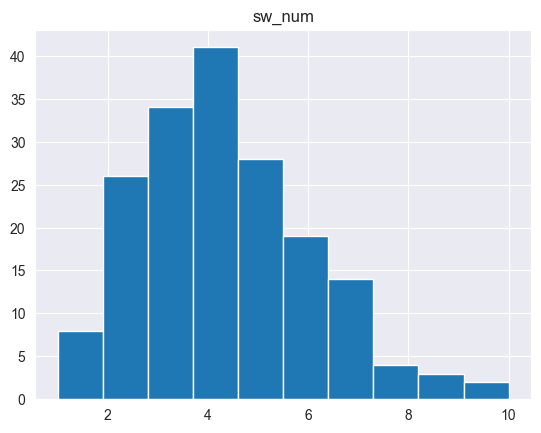

In [182]:
sw_df.hist();

In [183]:
# Comparison with sklearn stop words

len(sklearn_stop_words)

318

In [184]:
# Convert to set so we can use union and intersection operations
s1_sk = set(sklearn_stop_words)
s2_sw = set(stop_words)

print(len(s1_sk))
print(len(s2_sw))
HR()

# NTLK's list contains 60 stop words that aren't in the larger sklearn set.
print(len(s2_sw.union(s1_sk)))
HR()

print(len(s2_sw.intersection(s1_sk)))

318
179
----------------------------------------
378
----------------------------------------
119


<a name='2.2.5'></a><a id='2.2.5'></a>
### 2.2.5 Normalizing your vocabulary
<a href="#top">[back to top]</a>

Problem: We still need to reduce vocabulary size to improve the performance of a NLP pipeline and reduce overfitting.

Idea: We can "normalize" the corpus vocabulary, so that tokens meaning similar things are combined into a single, normalized form. This results in less tokens necessary, and improves the association of meaning across the different "spellings" of a token or n-gram. 

**Case Folding**

Problem: Some words feature multiple spellings and differ only in their capitalization.

Idea: *Case folding* or *case normalization* is a technique to return tokens to their normal state before grammar rules and position in the sentence affects their capitalization. Case normalizgin is particulary useful for search engines, since it increases "recall." However, there is a potential loss of information, or "precision", and many NLP pipelines do not normalize case at all. For many applications, the efficiency gain (in storage and processing) for reducing the corpus vocabulary by half is outweighed by the loss of semantic information for proper nouns. 

In [185]:
# Normalize the capitalization of tokens with a list comprehension
tokens = ['House', 'Visitor', 'Center']
print(tokens)
HR() 

normalized_tokens = [x.lower() for x in tokens]
print(normalized_tokens)

['House', 'Visitor', 'Center']
----------------------------------------
['house', 'visitor', 'center']


**Stemming**

Problem: Some words feature only small differences of pluralization, or possessive endings of words, or various verb forms.

Idea: *Stemming* is a normalization technique that identifies a common stem among the various forms of a word. Stemming removes suffixes from words. A stem is not required to be a properly spelled word, but merely a token that represents several possible word spellings. Stemming is important for keyword search or information retrieval. However, it greatly reduces the "precision" score, and sometimes increases the "false-positive" rate. 

In [186]:
# Simple stemmer implemented in Python
def stem(phrase):
    return ' '.join([re.findall('^(.*ss|.*?)(s)?$', word)[0][0].strip("'") for word in phrase.lower().split()])

print(stem('houses'))
print(stem("Doctor House's calls"))

house
doctor house call


In [187]:
# NLTK Porter stemmer
stemmer = PorterStemmer()
sentence = "dish washer's washed dishes"
print(sentence)
HR()
result = ' '.join([stemmer.stem(w).strip("'") for w in sentence.split()])
print(result)

dish washer's washed dishes
----------------------------------------
dish washer wash dish


**Lemmatization**

Problem: Some words contain semantic connections even though their spelling is different.

Idea: We can normalize words in this case by using lemmatization, which is extracts the semantic root of these words. Lemmatization is possibly a more accurate technique of normalization than stemming or case normalization because it encompasses semantic meaning. A lemmatizer uses a knowledge base of word synonyms and word endings to ensure only words that mean similar things are consolidated into a single token. Some lemmatizers also use the word's part of speech (POS) tag to help improve accuracy. In general, lemmatizers are better than stemmers for most applications. Th NLTK package provides popular lemmatizer operations.

In [188]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/gb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [189]:
lemmatizer.lemmatize("better")

'better'

In [190]:
lemmatizer.lemmatize("better", pos="a")

'good'

In [191]:
lemmatizer.lemmatize("good", pos="a")

'good'

In [192]:
lemmatizer.lemmatize("goods", pos="a")

'goods'

In [193]:
lemmatizer.lemmatize("goods", pos="n")

'good'

In [194]:
lemmatizer.lemmatize("goodness", pos="n")

'goodness'

In [195]:
lemmatizer.lemmatize("best", pos="a")

'best'

**Use Cases**

Problem: When should you use a lemmatizer or a stemmer?

Idea: In general, avoid stemming or lemmatization unless you have a limited amount of text that contains usage and capitalizations. This case may include documents with a lot of jargon, or are from a specialized subfield of science, technology, literature, etc. Usually, most NLP datasets are very big and do not require stemming or lemmatization. However, lemmatization may be useful for non-English languages.

<a name='2.3'></a><a id='2.3'></a>
## 2.3 Sentiment
<a href="#top">[back to top]</a>

Problem: Text may express a mood or sentiment and a complete understanding of such text requires measurement of its polarity.

Idea: Use sentiment analysis to systematically identify, extract, and quantify the polarity and subjective state of text. We can use either a rule-based algorithm, or a machine learning model which learns data algorithmically.

<a name='2.3.1'></a><a id='2.3.1'></a>
### 2.3.1 VADER - A rule-based sentiment analyzer

**Valence Aware Dictionary for Sentiment Reasoning**

* https://github.com/cjhutto/vaderSentiment
* https://ojs.aaai.org/index.php/ICWSM/article/view/14550

<a href="#top">[back to top]</a>

Problem: There are certain use-cases where specialized knowledge may be useful in determining sentiment.

Idea: Use a specialized lexicon, or dictionary that contain a collection of words and compiled using expert knowledge, having been collected for a specific purpose. One such lexicon is Valence Aware Dictionary for sEntiment Reasoning (VADER). This is available in the NLTK package as `nltk.sentiment.vader`. VADER is sensitive to both polarity and intensity of emotion. VADER was specifically designed to analyze social media content. A disadvantage of VADER is that it does not look at all words in a corpus, only about 7,500 words. To add more words, you must add to its dictionary in `SentimentIntensityAnalyzer.lexicon`, which also entails a prior knowledge of the corpus text. 


In [196]:
sa = SentimentIntensityAnalyzer()

# only show a portion
dict(list(sa.lexicon.items())[1000:1010])

{'beauteousness': 2.7,
 'beautician': 1.2,
 'beauticians': 0.4,
 'beauties': 2.4,
 'beautification': 1.9,
 'beautifications': 2.4,
 'beautified': 2.1,
 'beautifier': 1.7,
 'beautifiers': 1.7,
 'beautifies': 1.8}

In [197]:
test = pd.DataFrame([(tok, score) for tok, score in sa.lexicon.items()])

In [198]:
test.head(10)

,0,1
0,$:,-1.5
1,%),-0.4
2,%-),-1.5
3,&-:,-0.4
4,&:,-0.7
5,( '}{' ),1.6
6,(%,-0.9
7,('-:,2.2
8,(':,2.3
9,((-:,2.1


In [199]:
# Check for tokens containing spaces
[(tok, score) for tok, score in sa.lexicon.items() if " " in tok]

[("( '}{' )", 1.6),
 ("can't stand", -2.0),
 ('fed up', -1.8),
 ('screwed up', -1.5)]

In [200]:
sa.polarity_scores(text="Python is very readable and it's great for NLP.")

{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'compound': 0.6249}

In [201]:
sa.polarity_scores(text="Python is not a bad choice for most applications.")

{'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'compound': 0.431}

In [202]:
# Check how this rule-based approach works for our example statements.
corpus = [
    "Absolutely perfect! Love it! :-) :-) :-)",
    "Horrible! Completely useless. :(",
    "It was OK. Some good and some bad things."
]

for doc in corpus:
    scores = sa.polarity_scores(doc)
    print('{:+}: {}'.format(scores['compound'], doc))

+0.9428: Absolutely perfect! Love it! :-) :-) :-)
-0.8768: Horrible! Completely useless. :(
-0.1531: It was OK. Some good and some bad things.


<a name='2.3.2'></a><a id='2.3.2'></a>
### 2.3.2 Naive Bayes
<a href="#top">[back to top]</a>

Problem: There are cases where hand-coding algorithms is not efficient nor effective in sentiment analysis.

Idea: Use a Naive Bayes machine learning model to  automatically find keywords in the corpus that are predictive of the target variable. In the Naive Bayes model, the internal coefficients will map words or tokens to scores, as VADER does, which can be useful for explainability.

<a id='movieReviewSnippets_GroundTruth.csv.gz'></a><a name='movieReviewSnippets_GroundTruth.csv.gz'></a>
### Dataset: movieReviewSnippets_GroundTruth.csv.gz
<a href="#top">[back to top]</a>

In [203]:
data_dir = 'data/data_movie_review'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
          
data_movie_review = f"{data_dir}/movieReviewSnippets_GroundTruth.csv.gz"
!wget -P {data_dir} -nc https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/hutto_ICWSM_2014/movieReviewSnippets_GroundTruth.csv.gz
!ls -l {data_movie_review}

File ‘data/data_movie_review/movieReviewSnippets_GroundTruth.csv.gz’ already there; not retrieving.

-rw-r--r--  1 gb  staff  565697 Mar 25 11:08 data/data_movie_review/movieReviewSnippets_GroundTruth.csv.gz


In [204]:
movies = pd.read_csv(data_movie_review, compression="infer")

In [205]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10605 non-null  int64  
 1   sentiment  10605 non-null  float64
 2   text       10605 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 248.7+ KB


In [206]:
movies.head().round(2)

,id,sentiment,text
0,1,2.27,The Rock is destined to be the 21st Century's ...
1,2,3.53,The gorgeously elaborate continuation of ''The...
2,3,-0.60,Effective but too tepid biopic
3,4,1.47,If you sometimes like to go to the movies to h...
4,5,1.73,"Emerges as something rare, an issue movie that..."


In [207]:
movies.describe().round(2)

,id,sentiment
count,10605.00,10605.00
mean,5303.00,0.00
std,3061.54,1.92
min,1.00,-3.88
25%,2652.00,-1.77
50%,5303.00,-0.08
75%,7954.00,1.83
max,10605.00,3.94


Tokenize these movies reviews to create a bag of words for each one.

In [208]:
bags_of_words = []

for text in movies.text:
    bags_of_words.append(Counter(casual_tokenize(text)))
    
len(bags_of_words)

10605

In [209]:
%%time
# Creates a DataFrame object from a structured ndarray, sequence of tuples or dicts, or DataFrame.
print("Start")

# The from_records() DataFrame constructor takes a sequence of dictionaries. 
# It creates columns for all the keys, and the values are added to the table 
# in the appropriate columns, filling missing values with NaN
df_bows = pd.DataFrame.from_records(bags_of_words)
print("End")

Start
End
CPU times: user 56.7 s, sys: 8.3 s, total: 1min 4s
Wall time: 1min 5s


In [210]:
%%time
print("Start")
df_bows = df_bows.fillna(0).astype(int)
print("End")

Start
End
CPU times: user 2.56 s, sys: 3.41 s, total: 5.97 s
Wall time: 5.37 s


In [211]:
df_bows.shape

(10605, 20756)

In [212]:
df_bows.head()

,The,Rock,is,destined,to,be,the,21st,Century's,new,...,Ill,slummer,Rashomon,dipsticks,Bearable,Staggeringly,’,ve,muttering,dissing
0,1,1,1,1,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
df_bows.head()[list(bags_of_words[0].keys())]

,The,Rock,is,destined,to,be,the,21st,Century's,new,...,Schwarzenegger,",",Jean,Claud,Van,Damme,or,Steven,Segal,.
0,1,1,1,1,2,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,4,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [214]:
df_bows.shape

(10605, 20756)

We now have all the data in a data-structure that Naive Bayes model needs to find the keywords that predict sentiment from natural language text.

Note that Naive Bayes models are **classifiers**, so we need to convert our output variable (sentiment float) to a discrete label (integer, string, or bool).

In [215]:
nb = MultinomialNB()
nb = nb.fit(df_bows, movies.sentiment > 0)
nb

MultinomialNB()

Error, as per https://github.com/totalgood/nlpia/issues/33

`movies['predicted_sentiment'] = nb.predict_proba(df_bows) * 8 - 4`

Convert your binary classification variable (0 or 1) to -4 or 4 so you 
can compare it to the “ground truth” sentiment. Use `nb.predict_proba` 
to get a continuous value.

`nb.predict_proba` returns probability estimates for the test vector X.
This return an array-like of shape (n_samples, n_classes).
However, we only want the n_classes.
Use `[:, 1]` to specify 

In [216]:
movies['predicted_sentiment'] = nb.predict_proba(df_bows)[:, 1] * 8 - 4
movies['predicted_sentiment']

0        2.511515
1        3.999904
2       -3.655976
3        1.940954
4        3.910373
           ...   
10600   -3.166489
10601   -1.056805
10602   -1.481449
10603    3.988988
10604   -3.997954
Name: predicted_sentiment, Length: 10605, dtype: float64

In [217]:
movies['error'] = (movies.predicted_sentiment - movies.sentiment).abs()

In [218]:
movies.error.mean().round(1)

1.9

In [219]:
movies['sentiment_ispositive'] = (movies.sentiment > 0).astype(int)
movies['predicted_ispositive'] = (movies.predicted_sentiment > 0).astype(int)

In [220]:
movies.columns

Index(['id', 'sentiment', 'text', 'predicted_sentiment', 'error',
       'sentiment_ispositive', 'predicted_ispositive'],
      dtype='object')

In [221]:
movies['''sentiment predicted_sentiment sentiment_ispositive predicted_ispositive'''.split()].head(8)

,sentiment,predicted_sentiment,sentiment_ispositive,predicted_ispositive
0,2.266667,2.511515,1,1
1,3.533333,3.999904,1,1
2,-0.600000,-3.655976,0,0
3,1.466667,1.940954,1,1
4,1.733333,3.910373,1,1
5,2.533333,3.995188,1,1
6,2.466667,3.960466,1,1
7,1.266667,-1.918701,1,0


In [222]:
(movies.predicted_ispositive == movies.sentiment_ispositive).sum() / len(movies)

0.9344648750589345

---

### Extra

In order to build a real sentiment analyzer like this, we should split the training data, and leave out the test set. 

<a id='amazonReviewSnippets_GroundTruth.csv.gz'></a><a name='amazonReviewSnippets_GroundTruth.csv.gz'></a>
### Dataset: amazonReviewSnippets_GroundTruth.csv.gz
<a href="#top">[back to top]</a>

In [223]:
data_amazon_dir = 'data/data_amazonReviewSnippets_review'
if not os.path.exists(data_amazon_dir):
    os.makedirs(data_amazon_dir)
          
data_amazon_review = f"{data_amazon_dir}/amazonReviewSnippets_GroundTruth.csv.gz"
!wget -P {data_amazon_dir} -nc https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/hutto_ICWSM_2014/amazonReviewSnippets_GroundTruth.csv.gz
!ls -l {data_amazon_review}

File ‘data/data_amazonReviewSnippets_review/amazonReviewSnippets_GroundTruth.csv.gz’ already there; not retrieving.

-rw-r--r--  1 gb  staff  136281 Mar 25 11:10 data/data_amazonReviewSnippets_review/amazonReviewSnippets_GroundTruth.csv.gz


In [224]:
# Part 1

# hutto_products: amazonReviewSnippets_GroundTruth.csv.gz
products = pd.read_csv(data_amazon_review, compression="infer")

bags_of_words = []

for text in products.text:
    bags_of_words.append(Counter(casual_tokenize(text)))

df_product_bows = pd.DataFrame.from_records(bags_of_words)
df_product_bows = df_product_bows.fillna(0).astype(int)
df_product_bows.head()

,troubleshooting,ad,-,2500,and,2600,no,picture,scrolling,b,...,undone,warrranty,expire,expired,voids,develops,soldier,serving,baghdad,harddisk
0,1,2,2,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
df_all_bows = df_bows.append(df_product_bows)
print(df_all_bows.columns)
HR()

df_product_bows = df_all_bows.iloc[len(movies):][df_bows.columns]
print(df_all_bows.columns.values)
HR()

df_product_bows = df_all_bows.iloc[len(movies):][df_bows.columns]
print(df_product_bows.shape)
print(df_bows.shape)

Index(['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century's',
       'new',
       ...
       'sligtly', 'owner', '81', 'defectively', 'warrranty', 'expire',
       'expired', 'voids', 'baghdad', 'harddisk'],
      dtype='object', length=23302)
----------------------------------------
['The' 'Rock' 'is' ... 'voids' 'baghdad' 'harddisk']
----------------------------------------
(3546, 20756)
(10605, 20756)


In [226]:
df_product_bows.head()

,The,Rock,is,destined,to,be,the,21st,Century's,new,...,Ill,slummer,Rashomon,dipsticks,Bearable,Staggeringly,’,ve,muttering,dissing
0,NaN,NaN,0,NaN,0,0,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0,NaN,0,0,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0,NaN,0,0,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0,NaN,0,0,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0,NaN,1,0,2,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
# Need to fix nan again
df_product_bows = df_product_bows.fillna(0).astype(int)
df_product_bows.head()

,The,Rock,is,destined,to,be,the,21st,Century's,new,...,Ill,slummer,Rashomon,dipsticks,Bearable,Staggeringly,’,ve,muttering,dissing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
# Part 2
products['ispos'] = (products.sentiment > 0).astype(int)
products['pred'] = nb.predict(df_product_bows.values).astype(int)

In [229]:
products.head()

,id,sentiment,text,ispos,pred
0,1_1,-0.90,troubleshooting ad-2500 and ad-2600 no picture...,0,0
1,1_2,-0.15,"repost from january 13, 2004 with a better fit...",0,0
2,1_3,-0.20,does your apex dvd player only play dvd audio ...,0,0
3,1_4,-0.10,or does it play audio and video but scrolling ...,0,0
4,1_5,-0.50,before you try to return the player or waste h...,0,0


In [230]:
(products.pred == products.ispos).sum() / len(products)

0.5572476029328821

Note: While using the Naive Bayes model, we can use the VADER as a simple benchmark, checking whether a ML approach is better than hard-coded heuristics. 